<h1 align='center' style='font-family:"Trebuchet MS",sans-serif;font-size:40px'>CHIP CATEGORY CUSTOMER ANALYTICS</h1>

## Outline
(To go right to a certain portion of the notebook, click on any element of the outline.)
- <a href='#0' style='text-decoration:none'>0. Objective</a>
    - <a href='#0.1' style='text-decoration:none'>0.1 Importing Libraries</a>
    - <a href='#0.2' style='text-decoration:none'>0.2 Data Overview</a>
    

- <a href='#1' style='text-decoration:none'>1. Data preperation phase 1(Cleaning Transaction dataset)</a>
    - <a href='#1.1' style='text-decoration:none'>1.1 Filtering chip transaction </a>
    - <a href='#1.2' style='text-decoration:none'>1.2 Dealing with outliers </a>
    - <a href='#1.3' style='text-decoration:none'>1.3 Investigating the Date Dimension</a>
    - <a href='#1.4' style='text-decoration:none'>1.4 Feature Engineering</a>
        - <a href='#1.4.1' style='text-decoration:none'>1.4.1 Dealing with duplicate</a>
        

- <a href='#2' style='text-decoration:none'>2. Data preperation phase 2</a>
    - <a href='#2.1' style='text-decoration:none'>2.1 Cleaning customer dataset</a>
    - <a href='#2.2' style='text-decoration:none'>2.2 Merging transaction and customer dataset</a>


- <a href='#3' style='text-decoration:none'>3. Data Analysis</a>
    - <a href='#3.1' style='text-decoration:none'>3.1 Total Sales by customer segment</a>
    - <a href='#3.2' style='text-decoration:none'>3.2 Customer Segment distribution</a>
    - <a href='#3.3' style='text-decoration:none'>3.3 Average quantity of chips by customer segment</a>
    - <a href='#3.4' style='text-decoration:none'>3.4 Average price spent by customer segment</a>
    - <a href='#3.5' style='text-decoration:none'>3.5 T-test evaluation </a>
    - <a href='#3.6' style='text-decoration:none'>3.6 Analyzing customer segment of interest </a>
        - <a href='#3.6.1' style='text-decoration:none'>3.6.1 Brand preference </a>
        - <a href='#3.6.2' style='text-decoration:none'>3.6.2 Packet size preference </a>
    - <a href='#3.7' style='text-decoration:none'>3.7 Additional Insights </a>


- <a href='#4' style='text-decoration:none'>4. Conclusion and Recommendation </a>
    - <a href='#4.1' style='text-decoration:none'>4.1 Conclusion </a>
    - <a href='#4.2' style='text-decoration:none'>4.2 Recommendation </a>

# <a id='0'>0. Objective</a>

We have been approached by the Category Manager for Chips, who wants to better understand the types of customers who purchase Chips and their purchasing behaviour within the region.

The purpose of the project is to use analysis to obtain insights, which will be incorporated into the supermarket's chip category strategic plan for the next six months.

## <a id='0.1'>0.1 Importing Libraries</a>

In [117]:
# Importing Libraries for data handling
import numpy as np
import pandas as pd

# Importing Libraries for Visualisation 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing Library for t-test evaluation
from scipy.stats import ttest_ind

## <a id='0.1'>0.1 Data Overview</a>

For this analysis, there are two datasets: transaction data and customer data

In [118]:
#load data set
tran = pd.read_excel('QVI_transaction_data.xlsx')
cust = pd.read_csv('QVI_purchase_behaviour.csv')

In [119]:
# get no of rows and columns for transaction data
tran.shape

(264836, 8)

In [120]:
# get no of rows and columns for customer data
cust.shape

(72637, 3)

### Following is a brief summary of the datasets after viewing it in Excel.

The raw transaction data contains 264836 rows and 8 columns
>**DATE** - date of transaction
>
>**STORE_NBR** - store transaction occurred 
>
>**LYLTY_CARD_NBR** - A unique customer ID
>
>**TXN_ID** - unique transaction ID
>
>**PROD_NAME, PROD_NBR** - product name and unique product ID
>
>**PROD_QTY** - quantity of product sold
>
>**TOT_SALES** - total amount in sales of transaction

The raw customer data contains 72637 rows and 3 columns
>**LYLTY_CARD_NBR** - A unique customer ID
>
>**LIFESTAGE** - identifies whether a customer has a family or not and what point in life they are at
>
>**PREMIUM_CUSOTOMER** - Customer classification by the price point of products they buy and the types of products they buy

Both datasets have a unique customer ID, which I would be using to merge them

# <a id='1.'>1. Data preperation phase 1(Cleaning Transaction dataset)</a>

I will begin the first phase of data preparation by processing the transaction dataset

In [121]:
# get the first 3 records
tran.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9


In [122]:
# get general info
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


The date field is incorrectly formatted for some reason. Its data value (43390) appears to be an excel (int) data format denoting days after a base date (1899-12-30), therefore I will convert it to a datetime object.

In [123]:
# set base_date to 1899-12-30
base_date = pd.Timestamp('1899-12-30')

In [124]:
# create a function that converts integer to datetime
def int_to_date(date):
    date = base_date + pd.DateOffset(date)
    return date

In [125]:
# apply this function to the date column to convert it
tran['DATE'] = tran['DATE'].apply(int_to_date)

Now I'm going to create additional date columns, such as month and day of the week , that I believe will aid my analysis.

In [126]:
# create new month and day of week features using datetime attributes
tran['MONTH'] = tran['DATE'].apply(lambda time: time.month)
tran['DAY_OF_WEEK'] = tran['DATE'].apply(lambda time: time.dayofweek)

In [127]:
# check tran dataframe
tran.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,MONTH,DAY_OF_WEEK
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,10,2
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,5,1
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,5,0


All columns had 264836 entries in the .info() method. However, I would utilize the .isnull() function to ensure that there are no missing values.

In [128]:
tran.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
MONTH             0
DAY_OF_WEEK       0
dtype: int64

Great! There are no missing values

## <a id='1.1'>1.1 Filtering out chip transactions</a>

Because I'm only interested in chip transactions, I'll need to look at the product name column to filter them out.

In [129]:
# get first 10 values in prod_name column
tran['PROD_NAME'].head(10)

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
5    Old El Paso Salsa   Dip Tomato Mild 300g
6    Smiths Crinkle Chips Salt & Vinegar 330g
7       Grain Waves         Sweet Chilli 210g
8     Doritos Corn Chip Mexican Jalapeno 150g
9       Grain Waves Sour    Cream&Chives 210G
Name: PROD_NAME, dtype: object

In [130]:
len(tran['PROD_NAME'].unique())

114

There are 114 different product names so it would be difficult to know all of the real chip products right away. To obtain a clearer picture, I'll make a histogram of all of the words in the product name column and store it in a dictionary.

In [131]:
# create empty dictionary
prod_hist = dict()

#create word historgam
for prod in tran['PROD_NAME'].unique():
    prod = prod.split()
    for value in prod:
        # remove words starting with numbers and special characters
        if value[0] in ['0','1','2','3','4','5','6','7','8','9']: continue
        if value == '&': continue
        prod_hist[value] = prod_hist.get(value, 0) + 1

In [132]:
# insert dict into df and sort by count to get the most common words
word_df = pd.Series(prod_hist).reset_index()
word_df.rename({'index':'word', 0:'count'}, axis=1, inplace=True)
word_df.sort_values(by='count', ascending=False).head(20)

,word,count
10,Chips,21
7,Smiths,16
9,Cut,14
8,Crinkle,14
14,Kettle,13
6,Cheese,12
25,Salt,12
45,Original,10
1,Chip,9
21,Salsa,9


There are many words, but I'm particularly interested in crucial words that have a meaning that differ from that of a chip. Salsa and chip, for example, should not be used in the same product name because they have different meanings. But first, let's look at the names that contain the term 'Salsa.'

In [133]:
salsa_df = tran[tran['PROD_NAME'].str.contains('Salsa', regex=False)]
len(salsa_df)

18094

In [134]:
salsa_df['PROD_NAME'].unique()

array(['Old El Paso Salsa   Dip Tomato Mild 300g',
       'Red Rock Deli SR    Salsa & Mzzrlla 150g',
       'Smiths Crinkle Cut  Tomato Salsa 150g',
       'Doritos Salsa       Medium 300g',
       'Old El Paso Salsa   Dip Chnky Tom Ht300g',
       'Woolworths Mild     Salsa 300g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'Woolworths Medium   Salsa 300g', 'Doritos Salsa Mild  300g'],
      dtype=object)

All of these products are definitely not chips, hence I'd get rid of them.

In [135]:
# remove non-chip transactions
chip_df = tran[~tran['PROD_NAME'].str.contains('Salsa', regex=False)]

In [136]:
chip_df.shape
# no of rows has reduced, so action was successful

(246742, 10)

## <a id='1.2'>1.2 Dealing with Outliers</a>

I would like to get the mean, min, and max values for both the product quantity and total sales columns before I look for outliers.

In [137]:
# check summary of continuos variables
chip_df.describe()[['PROD_QTY','TOT_SALES']].T[['count','mean','min','max', '50%']].rename({'50%':'median'}, axis=1)

,count,mean,min,max,median
PROD_QTY,246742.0,1.908062,1.0,200.0,2.0
TOT_SALES,246742.0,7.321322,1.7,650.0,7.4


Both maximum values are much greater than their respective central values (mean & median), which could indicate presence of outliers, but I'd look into it further by producing a boxplot of these continuous variables.

<AxesSubplot:ylabel='PROD_QTY'>

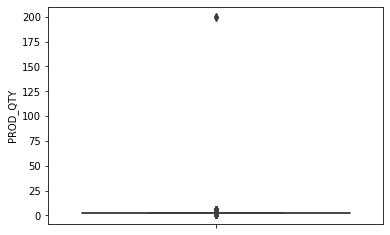

In [138]:
sns.boxplot(y='PROD_QTY', data = chip_df)

<AxesSubplot:ylabel='TOT_SALES'>

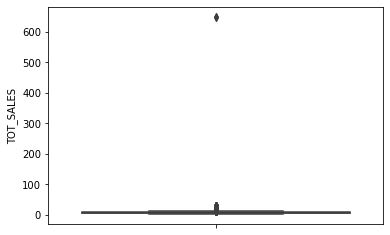

In [139]:
sns.boxplot(y='TOT_SALES', data = chip_df)

There are definitely outliers now lets remove them from the data set

In [140]:
chip_df[(chip_df['PROD_QTY'] > 100) | (chip_df['TOT_SALES'] > 400)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,MONTH,DAY_OF_WEEK
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,8,6
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,5,0


In [141]:
# check how transaction this customer made
sum(chip_df['LYLTY_CARD_NBR'] == 226000)

2

This customer had only two transactions; he or she most likely purchased it for a one-time event that would not occur on a regular basis, so I will proceed to delete the two transactions.

In [142]:
outlier_index = chip_df[(chip_df['PROD_QTY'] > 100) | (chip_df['TOT_SALES'] > 400)].index

In [143]:
chip_df = chip_df.drop(outlier_index)

<AxesSubplot:ylabel='PROD_QTY'>

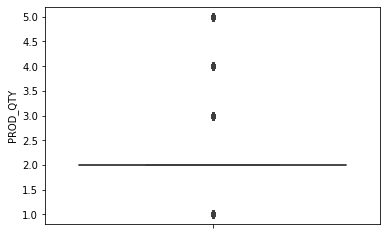

In [144]:
# lets check the box plot again
sns.boxplot(y='PROD_QTY', data = chip_df)

It seems that 97 percent of the values in the PROD QTY column are 2.0, which is why 1,3,4,5 appear as outliers even though the range (1-5) is not large.

## <a id='1.3'>1.3 Investigating the Date dimension</a>

In [145]:
# no of unique dates
chip_df['DATE'].nunique()
# It is just one day short of being a year. Let's check the date range

364

In [146]:
chip_df['DATE'].sort_values()

9161     2018-07-01
155442   2018-07-01
181349   2018-07-01
229948   2018-07-01
104647   2018-07-01
            ...    
10254    2019-06-30
113220   2019-06-30
229182   2019-06-30
229015   2019-06-30
262768   2019-06-30
Name: DATE, Length: 246740, dtype: datetime64[ns]

The period ran from July 1, 2018 to June 30, 2019. I need to find the missing date. To achieve this, I'd make a date sequence for this time period and join it with the groupby date dataframe.

In [147]:
date_group = chip_df.groupby('DATE').count()['PROD_QTY'].reset_index().rename({'PROD_QTY':'Count'}, axis=1)

In [148]:
dt_range = pd.date_range('2018-07-01', periods=365, freq='D')

In [149]:
comp_date = pd.DataFrame({'DATE':dt_range, 'Place_holder':0})

In [150]:
merged_date = pd.merge(comp_date, date_group, on=['DATE'], how='left')
merged_date

,DATE,Place_holder,Count
0,2018-07-01,0,663.0
1,2018-07-02,0,650.0
2,2018-07-03,0,674.0
3,2018-07-04,0,669.0
4,2018-07-05,0,660.0
...,...,...,...
360,2019-06-26,0,657.0
361,2019-06-27,0,669.0
362,2019-06-28,0,673.0
363,2019-06-29,0,703.0


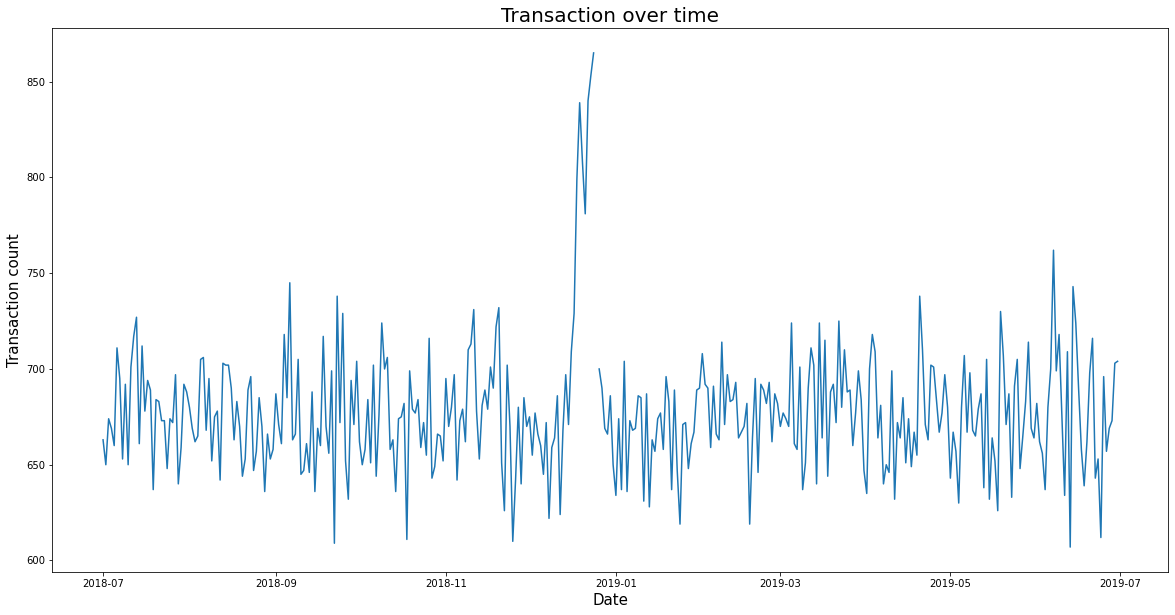

In [151]:
plt.figure(figsize = (20,10))
plt.plot(merged_date['DATE'], merged_date['Count'])
plt.ylabel('Transaction count', size=15)
plt.xlabel('Date', size=15)
plt.title('Transaction over time', size=20)
plt.show()

The number of transations increased greatlt just before the plot's break in December. Let's take a closer look at the plot for just December.

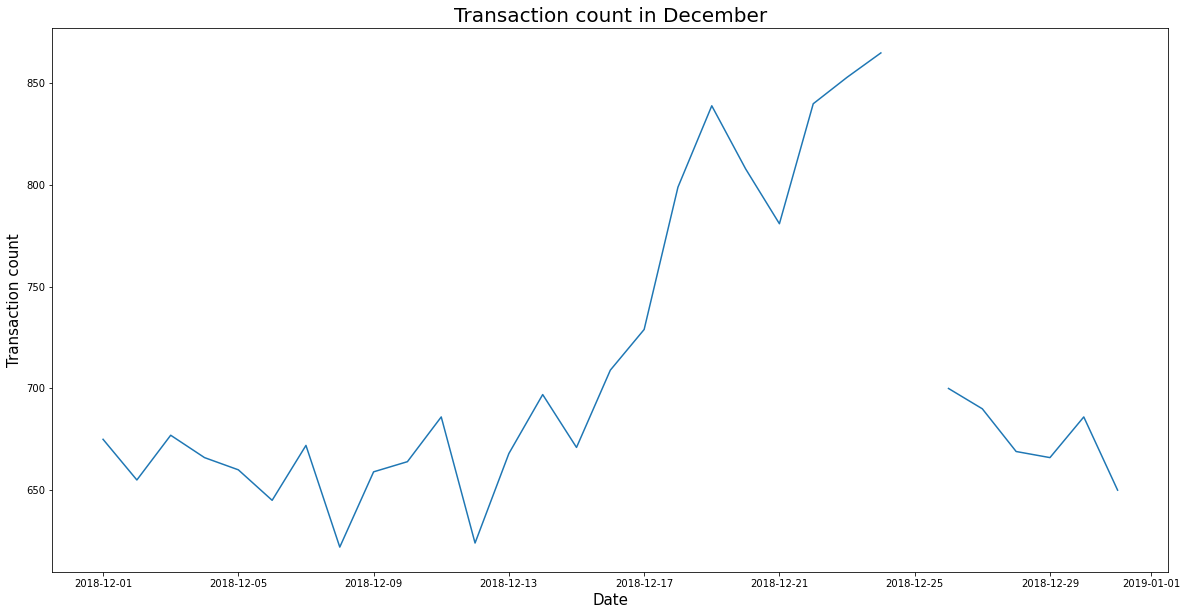

In [152]:
plt.figure(figsize = (20,10))
x = merged_date[merged_date['DATE'].apply(lambda time: time.month) == 12]['DATE']
y = merged_date[merged_date['DATE'].apply(lambda time: time.month) == 12]['Count']
plt.plot(x,y)
plt.ylabel('Transaction count', size=15)
plt.xlabel('Date', size=15)
plt.title('Transaction count in December', size=20)
plt.show()

The number of transactions surged just before Christmas. According to the plot, there were no transactions on 2018-12-25 (Christmas Day), which makes sense given that we expect increased purchases over the holidays and no sales on Christmas Day due to store closures.

In [153]:
# Verify that christmas day was the missing date
merged_date[merged_date['Count'].isnull()]

,DATE,Place_holder,Count
177,2018-12-25,0,NaN


## <a id='1.4'> 1.4 Feature Engineering</a>

I can now continue on to creating other features, such as chip brand or pack size, based on the product name. I'll begin with the pack size.

In [154]:
chip_df['PACKET_SIZE'] = chip_df['PROD_NAME'].str.extract(pat = '([0-9]+)')

In [155]:
# make sure all values data-type are integers
chip_df['PACKET_SIZE'] = chip_df['PACKET_SIZE'].apply(lambda v: int(v))

In [156]:
# checking the packet_size feature
chip_df['PACKET_SIZE'].value_counts().sort_index()

70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: PACKET_SIZE, dtype: int64

In [157]:
# confirm that the packet_size columns contains no missing value
chip_df['PACKET_SIZE'].isnull().sum()

0

This column's values are in the range of 70 to 380, which is reasonable. Also, there are no missing values in the column.

<AxesSubplot:xlabel='PACKET_SIZE', ylabel='Count'>

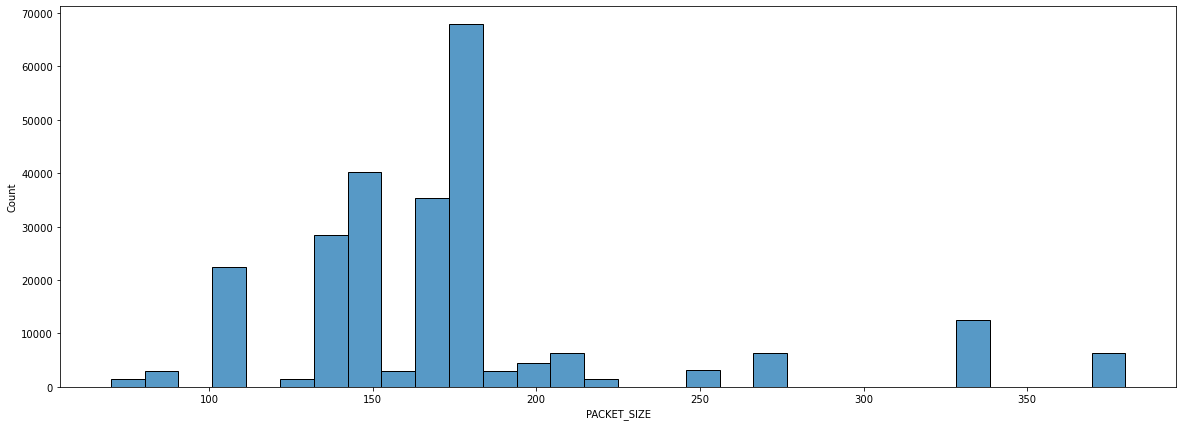

In [158]:
# plot packet_size histogram
plt.figure(figsize=(20,7))
sns.histplot(x=chip_df['PACKET_SIZE'], bins=30)

1The most purchased packet size was 175g, followed by sizes between 140 and 150g, and then 160g.

In [159]:
# create brand feature from product name
chip_df['BRAND'] = chip_df['PROD_NAME'].str.split(expand=True)[0]

In [160]:
chip_df['BRAND'].value_counts()

Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND, dtype: int64

Some brands appear to have been shortened or spelled differently, so let's see whether they're all the same.

Currently, I suspect that the folowing brands are the same:
- Red == RRD
- Natural == NCC
- Woolworths == WW
- Cheezels/Cheetos == CCs
- Infzns == Infuzions
- Grain == GranWves
- Smith == Smiths
- Sunbites == Snbts
- Dorito == Doritos

### <a id='1.4.1'> 1.4.1 Dealing with duplicate in brand</a>

**Checking 'Red' and 'RRD'**

In [161]:
chip_df[chip_df['BRAND'] == 'Red']['PROD_NAME'].value_counts()

Red Rock Deli Sp    Salt & Truffle 150G    1498
Red Rock Deli Thai  Chilli&Lime 150g       1495
Red Rock Deli Chikn&Garlic Aioli 150g      1434
Name: PROD_NAME, dtype: int64

In [162]:
chip_df[chip_df['BRAND'] == 'RRD']['PROD_NAME'].value_counts()

RRD SR Slow Rst     Pork Belly 150g     1526
RRD Sweet Chilli &  Sour Cream 165g     1516
RRD Honey Soy       Chicken 165g        1513
RRD Chilli&         Coconut 150g        1506
RRD Salt & Vinegar  165g                1474
RRD Lime & Pepper   165g                1473
RRD Steak &         Chimuchurri 150g    1455
RRD Pc Sea Salt     165g                1431
Name: PROD_NAME, dtype: int64

The red brand represents Red Rock Deli, which is the RRD brand's full name

**Checking 'Natural' and 'NCC'**

In [163]:
chip_df[chip_df['BRAND'] == 'Natural']['PROD_NAME'].value_counts()

Natural Chip Co     Tmato Hrb&Spce 175g    1572
Natural ChipCo Sea  Salt & Vinegr 175g     1550
Natural Chip        Compny SeaSalt175g     1468
Natural ChipCo      Hony Soy Chckn175g     1460
Name: PROD_NAME, dtype: int64

In [164]:
chip_df[chip_df['BRAND'] == 'NCC']['PROD_NAME'].value_counts()

NCC Sour Cream &    Garden Chives 175g    1419
Name: PROD_NAME, dtype: int64

Suspicion was correct as Natural represented Natural Chip Co/Company which is same thing as NCC

**Checking 'WW' and 'WoolWorths'**

In [165]:
chip_df[chip_df['BRAND'] == 'WW']['PROD_NAME'].value_counts()

WW Supreme Cheese   Corn Chips 200g       1509
WW Original Corn    Chips 200g            1495
WW Original Stacked Chips 160g            1487
WW Sour Cream &OnionStacked Chips 160g    1483
WW D/Style Chip     Sea Salt 200g         1469
WW Crinkle Cut      Chicken 175g          1467
WW Crinkle Cut      Original 175g         1410
Name: PROD_NAME, dtype: int64

In [166]:
chip_df[chip_df['BRAND'] == 'Woolworths']['PROD_NAME'].value_counts()

Woolworths Cheese   Rings 190g    1516
Name: PROD_NAME, dtype: int64

The woolworth brand contains only one of the company's product, the other products are other WW brand name so we would merge this two as well

CCs and cheezels / cheetos

**Checking 'CCs' and 'Cheezels' / 'Cheetos**

In [167]:
chip_df[chip_df['BRAND'] == 'CCs']['PROD_NAME'].value_counts()

CCs Tasty Cheese    175g    1539
CCs Original 175g           1514
CCs Nacho Cheese    175g    1498
Name: PROD_NAME, dtype: int64

In [168]:
chip_df[chip_df['BRAND'] == 'Cheezels']['PROD_NAME'].value_counts()

Cheezels Cheese 330g        3149
Cheezels Cheese Box 125g    1454
Name: PROD_NAME, dtype: int64

In [169]:
chip_df[chip_df['BRAND'] == 'Cheetos']['PROD_NAME'].value_counts()

Cheetos Chs & Bacon Balls 190g    1479
Cheetos Puffs 165g                1448
Name: PROD_NAME, dtype: int64

Cheetos is defintely a brand on its own, However it seems like CCs could mean Cheezels Cheese but after further research on the chip industry I confirmed that CC's stands for Corn chip

**Checking 'Infuzions' and 'Infzns'**

In [170]:
chip_df[chip_df['BRAND'] == 'Infuzions']['PROD_NAME'].value_counts()

Infuzions Thai SweetChili PotatoMix 110g    3242
Infuzions BBQ Rib   Prawn Crackers 110g     3174
Infuzions SourCream&Herbs Veg Strws 110g    3134
Infuzions Mango     Chutny Papadums 70g     1507
Name: PROD_NAME, dtype: int64

In [171]:
chip_df[chip_df['BRAND'] == 'Infzns']['PROD_NAME'].value_counts()

Infzns Crn Crnchers Tangy Gcamole 110g    3144
Name: PROD_NAME, dtype: int64

Infzns contains just one product, the other brand product are under infuzions

**Checking 'Grain' and 'GrnWves'**

In [172]:
chip_df[chip_df['BRAND'] == 'Grain']['PROD_NAME'].value_counts()

Grain Waves         Sweet Chilli 210g    3167
Grain Waves Sour    Cream&Chives 210G    3105
Name: PROD_NAME, dtype: int64

In [173]:
chip_df[chip_df['BRAND'] == 'GrnWves']['PROD_NAME'].value_counts()

GrnWves Plus Btroot & Chilli Jam 180g    1468
Name: PROD_NAME, dtype: int64

Also the Grain and GrnWves are the same brand

**Checking 'Smith' and 'Smiths'**

In [174]:
chip_df[chip_df['BRAND'] == 'Smiths']['PROD_NAME'].value_counts()

Smiths Crnkle Chip  Orgnl Big Bag 380g      3233
Smiths Crinkle Chips Salt & Vinegar 330g    3197
Smiths Crinkle      Original 330g           3142
Smiths Chip Thinly  Cut Original 175g       1614
Smiths Thinly Cut   Roast Chicken 175g      1519
Smiths Crinkle Cut  Snag&Sauce 150g         1503
Smiths Crinkle Cut  Chips Barbecue 170g     1489
Smiths Crinkle Cut  Chips Chicken 170g      1484
Smiths Crinkle Cut  Chips Chs&Onion170g     1481
Smiths Chip Thinly  S/Cream&Onion 175g      1473
Smiths Crinkle Cut  Chips Original 170g     1461
Smiths Thinly       Swt Chli&S/Cream175G    1461
Smiths Crinkle Cut  Salt & Vinegar 170g     1455
Smiths Chip Thinly  CutSalt/Vinegr175g      1440
Smiths Crinkle Cut  French OnionDip 150g    1438
Name: PROD_NAME, dtype: int64

In [175]:
chip_df[chip_df['BRAND'] == 'Smith']['PROD_NAME'].value_counts()

Smith Crinkle Cut   Mac N Cheese 150g    1512
Smith Crinkle Cut   Bolognese 150g       1451
Name: PROD_NAME, dtype: int64

These two are also the same

**Checking 'Sunbites' and 'Snbts'**

In [176]:
chip_df[chip_df['BRAND'] == 'Sunbites']['PROD_NAME'].value_counts()

Sunbites Whlegrn    Crisps Frch/Onin 90g    1432
Name: PROD_NAME, dtype: int64

In [177]:
chip_df[chip_df['BRAND'] == 'Snbts']['PROD_NAME'].value_counts()

Snbts Whlgrn Crisps Cheddr&Mstrd 90g    1576
Name: PROD_NAME, dtype: int64

Both brands contain just one product with 'Whlgrn' and 'Whlegrn' most likely meaning the same thing. Therefore I will merge these too

**Checking 'Doritos' and 'Dorito'**

In [178]:
chip_df[chip_df['BRAND'] == 'Doritos']['PROD_NAME'].value_counts()

Doritos Corn Chips  Cheese Supreme 170g    3217
Doritos Corn Chip Mexican Jalapeno 150g    3204
Doritos Corn Chip Southern Chicken 150g    3172
Doritos Corn Chips  Nacho Cheese 170g      3160
Doritos Corn Chips  Original 170g          3121
Doritos Mexicana    170g                   3115
Doritos Cheese      Supreme 330g           3052
Name: PROD_NAME, dtype: int64

In [179]:
chip_df[chip_df['BRAND'] == 'Dorito']['PROD_NAME'].value_counts()

Dorito Corn Chp     Supreme 380g    3183
Name: PROD_NAME, dtype: int64

Now, that I have confirm similar brands, I would merge them

In [180]:
# change red to rrd
chip_df.loc[chip_df['BRAND'] == 'Red', 'BRAND'] = 'RRD'

In [181]:
# change Natural to NCC
chip_df.loc[chip_df['BRAND'] == 'Natural', 'BRAND'] = 'NCC'

In [182]:
# change Woolworths to WW
chip_df.loc[chip_df['BRAND'] == 'Woolworths', 'BRAND'] = 'WW'

In [183]:
# change Infzns to Infuzions
chip_df.loc[chip_df['BRAND'] == 'Infzns', 'BRAND'] = 'Infuzions'

In [184]:
# change Grain to Grnwvs
chip_df.loc[chip_df['BRAND'] == 'Grain', 'BRAND'] = 'GrnWves'

In [185]:
# change Smith to Smiths
chip_df.loc[chip_df['BRAND'] == 'Smith', 'BRAND'] = 'Smiths'

In [186]:
# change Snbts to Sunbites
chip_df.loc[chip_df['BRAND'] == 'Snbts', 'BRAND'] = 'Sunbites'

In [187]:
# change Dorito to Doritos
chip_df.loc[chip_df['BRAND'] == 'Dorito', 'BRAND'] = 'Doritos'

In [188]:
# Lets examine the BRAND column again
chip_df['BRAND'].value_counts()

Kettle       41288
Smiths       30353
Doritos      25224
Pringles     25102
RRD          16321
Infuzions    14201
Thins        14075
WW           11836
Cobs          9693
Tostitos      9471
Twisties      9454
GrnWves       7740
NCC           7469
Tyrrells      6442
Cheezels      4603
CCs           4551
Sunbites      3008
Cheetos       2927
Burger        1564
French        1418
Name: BRAND, dtype: int64

In [189]:
# Verify there are no missing values after feature engineering
chip_df.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
MONTH             0
DAY_OF_WEEK       0
PACKET_SIZE       0
BRAND             0
dtype: int64

Perfect! this dataset is good to go

# <a id='2'>2. Data preperation phase 2</a>

For the second phase of the data preparation, I would clean the customer data set before merging it with the cleaned transaction dataset

## <a id='2.1'> 2.1 Processing Customer dataset</a>

In [190]:
cust.head(3)
#we have just 3 columns

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget


In [191]:
# check for duplicate
sum(cust.duplicated('LYLTY_CARD_NBR'))

0

In [192]:
# check for missing values
cust.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [193]:
cust.nunique()

LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [194]:
chip_df['LYLTY_CARD_NBR'].nunique()

71287

In [195]:
cust['LIFESTAGE'].value_counts()

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

In [196]:
cust['PREMIUM_CUSTOMER'].value_counts()

Mainstream    29245
Budget        24470
Premium       18922
Name: PREMIUM_CUSTOMER, dtype: int64

The lifestage feature has 7 categories while the premium_customer feature has 3 categories. All these are relevant for the analysis therefore I would proceed to merge this with the transaction data

## <a id='2.2'> 2.2 Merging the transaction and customer dataset</a>

In [197]:
df = pd.merge(chip_df, cust, how='left', on='LYLTY_CARD_NBR')

In [198]:
# confirm that no of rows remained the same
df.shape[0] == chip_df.shape[0]

True

In [199]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,MONTH,DAY_OF_WEEK,PACKET_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,10,2,175,NCC,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,5,1,175,CCs,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,5,0,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,8,4,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,8,5,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [200]:
df.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
MONTH               0
DAY_OF_WEEK         0
PACKET_SIZE         0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [201]:
df.to_csv('ChipTransactions.csv')

# <a id='3'>3. Data Analysis </a>

Before I commence analysis, I will state insights of interest that will serve as the basis to form a successful strategy for the following 6 months. I am interested in the following
- Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What's the average chip price by customer segment

## <a id='3.1'> 3.1 Total Sales by customer segment</a>

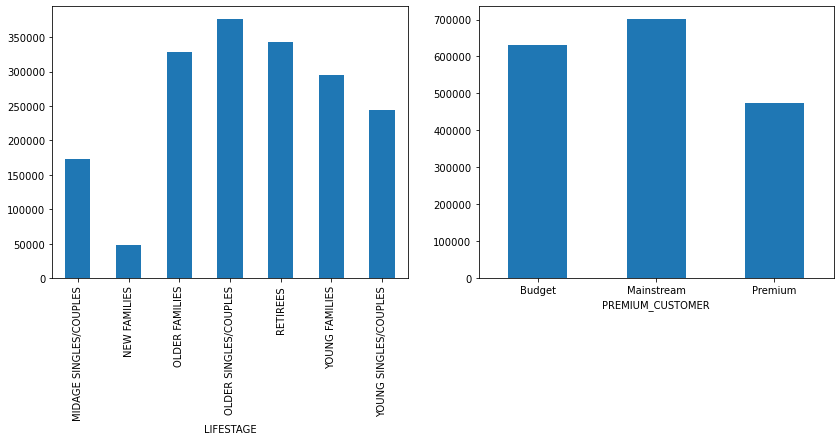

In [202]:
ax, fig = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
plt.subplot(1,2,1)
df.groupby('LIFESTAGE').sum()['TOT_SALES'].plot.bar()
plt.subplot(1,2,2)
df.groupby('PREMIUM_CUSTOMER').sum()['TOT_SALES'].plot.bar()
plt.xticks(rotation=0)
plt.show()
# plt.show()

Observation:
- Overall, Older singles/couples spent the most money on chips followed by retirees and older families
- In general, Mainstream customers bought in the most money on chips while Premium customers spent the least

I would also check the purchasing behaviour in older singles/couples as well as Life stages of the mainstream customer to identify which part of these groups that spend the most money

<AxesSubplot:xlabel='LIFESTAGE'>

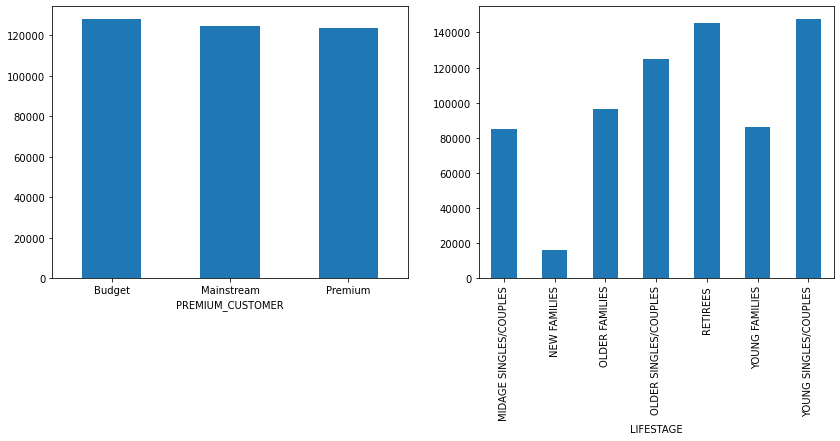

In [203]:
ax, fig = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
plt.subplot(1,2,1)
df[df['LIFESTAGE'] == 'OLDER SINGLES/COUPLES'].groupby('PREMIUM_CUSTOMER').sum()['TOT_SALES'].plot.bar()
plt.xticks(rotation=0)
plt.subplot(1,2,2)
df[df['PREMIUM_CUSTOMER'] == 'Mainstream'].groupby('LIFESTAGE').sum()['TOT_SALES'].plot.bar()

Observation: 
- Although the older singles/couples on a budget spent the most, all three spent almost the same amount on chips.
- Young singles/couples and retirees both spent the most on chip in the mainstream category, with the former paying just slightly more than the latter.

Finally I would get the total sales from every segments

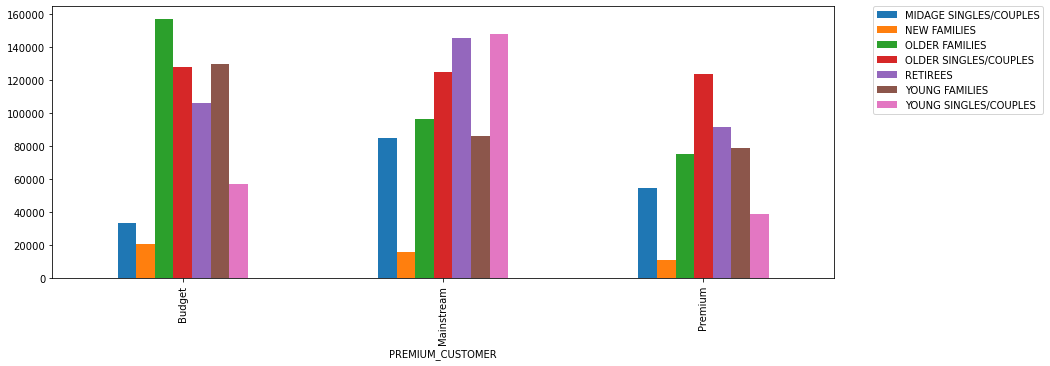

In [204]:
df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).sum()['TOT_SALES'].unstack().plot.bar(figsize = (14,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

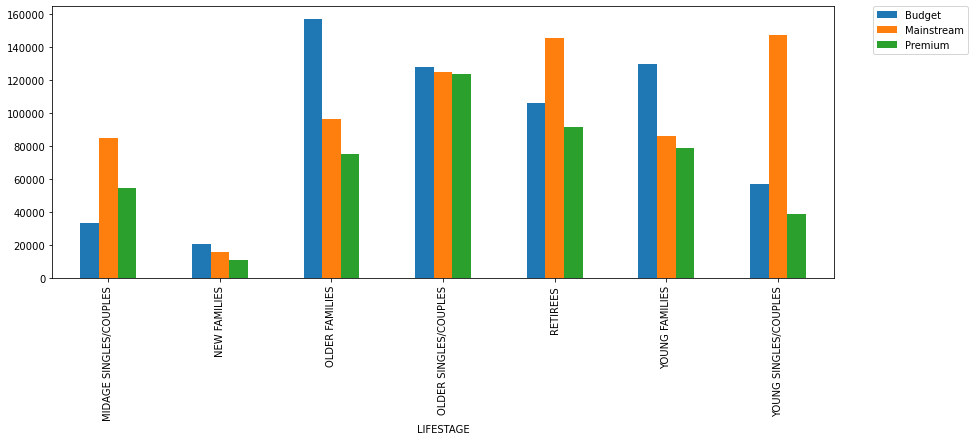

In [205]:
df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).sum()['TOT_SALES'].unstack().plot.bar(figsize = (14,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Observation:
- Across all purchasing behaviours, new families spent the least, this could be due to the number of customers in this category
- Overall, the customer segment spending the most was budget - older families, followed by mainstream - young singles/couples and mainstream - retirees
- Also premium spent the least in all lifestage categories except the premium - midage singles/couples who spent more that their budget counterparts

## <a id='3.2'> 3.2 Customer Segment distribution</a>

Let's get a dataframe containing all unique chip customers and their respective purchasing behaviour and lifestage

In [206]:
chip_customers = df['LYLTY_CARD_NBR'].unique()

In [207]:
def get_chip_customer(cus):
    if cus in chip_customers:
        return True
    else:
        return False

In [208]:
chip_cust = cust[cust['LYLTY_CARD_NBR'].apply(get_chip_customer)]

In [209]:
chip_cust.shape[0] == chip_df['LYLTY_CARD_NBR'].nunique()

True

In [210]:
chip_cust.groupby('LIFESTAGE').count()['LYLTY_CARD_NBR']

LIFESTAGE
MIDAGE SINGLES/COUPLES     7141
NEW FAMILIES               2492
OLDER FAMILIES             9630
OLDER SINGLES/COUPLES     14389
RETIREES                  14555
YOUNG FAMILIES             9036
YOUNG SINGLES/COUPLES     14044
Name: LYLTY_CARD_NBR, dtype: int64

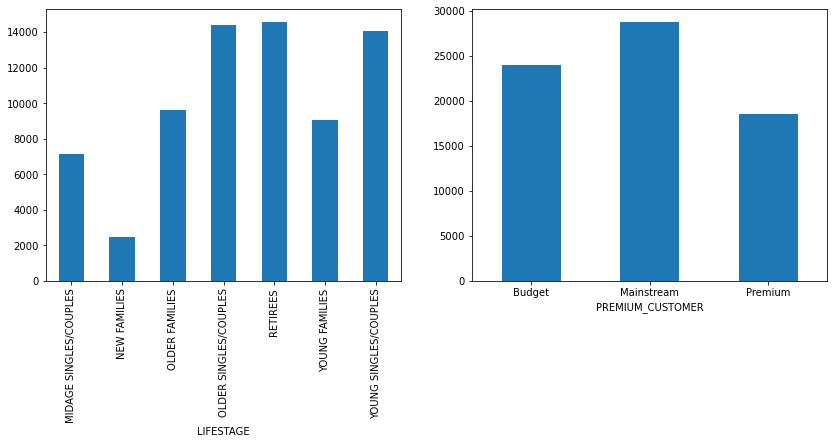

In [211]:
ax, fig = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
plt.subplot(1,2,1)
chip_cust.groupby('LIFESTAGE').count()['LYLTY_CARD_NBR'].plot.bar()

plt.subplot(1,2,2)
chip_cust.groupby('PREMIUM_CUSTOMER').count()['LYLTY_CARD_NBR'].plot.bar()
plt.xticks(rotation=0)
plt.show()

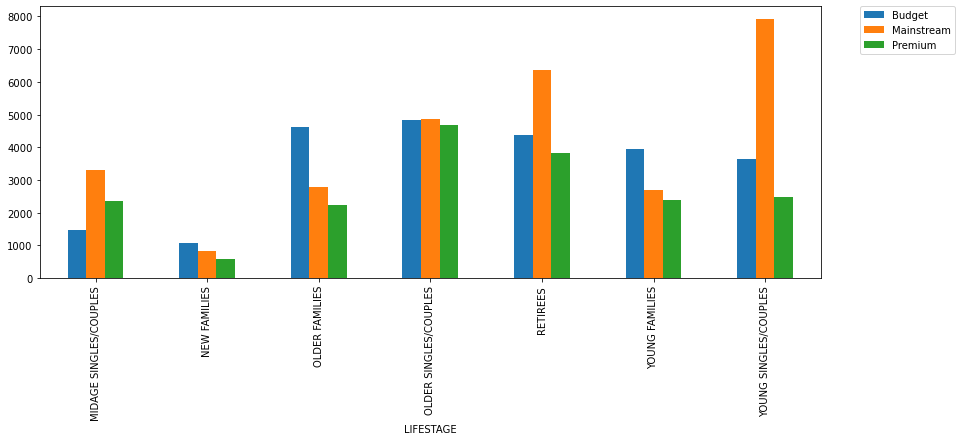

In [212]:
chip_cust.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).count()['LYLTY_CARD_NBR'].unstack().plot.bar(figsize = (14,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Observation:
- Most chip customers were Mainstream - young singles/couples and retirees. This could be the driving force behind the high amount of money spent by these customer segments. 
- All purchasing behaviour for older singles/couples had about the same number of customers just behind the two biggest customer segments
- budget - older families    Average price spent by customer 

## <a id='3.3'> 3.3 Average quantity of chips by customer segment </a>

In [213]:
 = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({'PROD_QTY': ['mean', 'sum']})
qty_stat.columns = ['PROD_QTY_MEAN', 'PROD_QTY_SUM']

In [251]:
qty_stat = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique()
qty_stat1 = qty_stat.reset_index()
qty_stat1.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'AVG_PROD_PER_COST']
qty_stat1.sort_values(by='AVG_PROD_PER_COST', ascending=False)

,LIFESTAGE,PREMIUM_CUSTOMER,AVG_PROD_PER_COST
7,OLDER FAMILIES,Mainstream,9.255380
6,OLDER FAMILIES,Budget,9.076773
8,OLDER FAMILIES,Premium,9.071717
15,YOUNG FAMILIES,Budget,8.722995
17,YOUNG FAMILIES,Premium,8.716013
16,YOUNG FAMILIES,Mainstream,8.638361
9,OLDER SINGLES/COUPLES,Budget,6.781398
11,OLDER SINGLES/COUPLES,Premium,6.769543
10,OLDER SINGLES/COUPLES,Mainstream,6.712021
1,MIDAGE SINGLES/COUPLES,Mainstream,6.432080


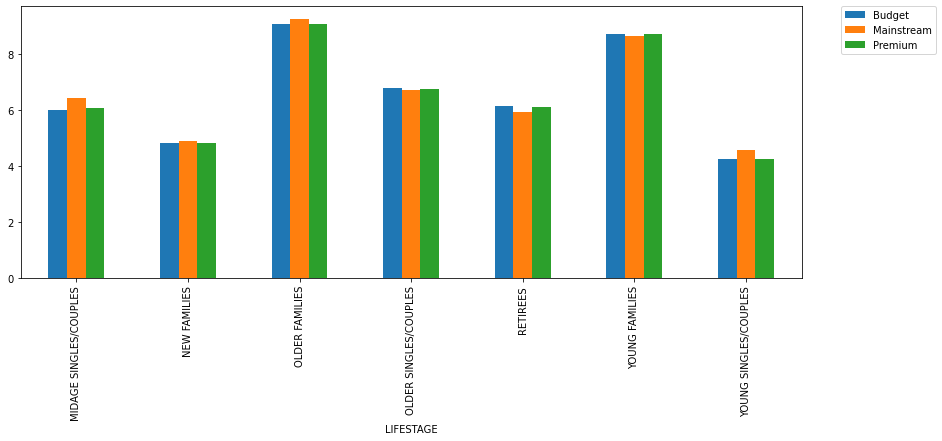

In [253]:
qty_stat.unstack().plot.bar(figsize = (14,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Observation:
- Older families and young families buy more  chips on average per transaction. This is the driving force for the amount sales brought in by budget - older families
- Young singles/couples and new families buy the least amount of chips on average per transaction. We could speculate that this is a result of having little to no children in this group who enjoy chips more

## <a id='3.4' > 3.4 Average price spent by customer segment </a>

In [254]:
ppu_stat = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).sum()['TOT_SALES'] / df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).sum()['PROD_QTY']

In [256]:
ppu_stat1 = ppu_stat.reset_index()
ppu_stat1.columns = ['LIFESTAGE', 'PREMIUM_CUSTOMER', 'AVG_PRICE_PER_UNIT']
ppu_stat1.sort_values(by='AVG_PRICE_PER_UNIT', ascending=False)

,LIFESTAGE,PREMIUM_CUSTOMER,AVG_PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,3.994449
4,NEW FAMILIES,Mainstream,3.935887
12,RETIREES,Budget,3.932731
3,NEW FAMILIES,Budget,3.931969
14,RETIREES,Premium,3.924037
11,OLDER SINGLES/COUPLES,Premium,3.897698
9,OLDER SINGLES/COUPLES,Budget,3.887529
5,NEW FAMILIES,Premium,3.886168
13,RETIREES,Mainstream,3.852986


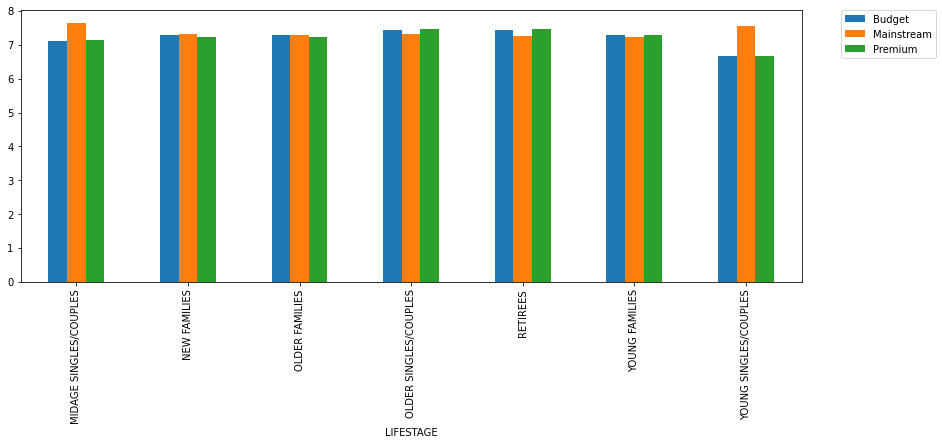

In [218]:
ppu_stat.unstack().plot.bar(figsize = (14,5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Observation:
- There appears to be a significant difference in average chip spending among different purchasing behaviors for both midage and young singles/couples, as the mainstream categories of both life stages accounted for the top two average spenders per transaction, whereas their budget and premium counterparts were the least average spenders.
- Therefore, in comparison to their budget and premium peers, mainstream midage and young individuals and couples are more willing to pay more per packet of chips. This may be due to premium shoppers being more likely to buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer premium midage and young singles and couples buying chips compared to their mainstream counterparts.

## <a id='3.5' > 3.5 T-test evaluation </a>

Since the difference between the mean values for premium - midage and young singles/couples and their budget and mainstream is small, I will perform a t-test to verify that these two data are statistically different.

In [219]:
main = df[((df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')|(df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')) &
          (df['PREMIUM_CUSTOMER'] == 'Mainstream')]

In [220]:
bud_pre = df[((df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES')|(df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES')) &
          (df['PREMIUM_CUSTOMER'] != 'Mainstream')]

In [221]:
ttest_ind(main['TOT_SALES'], bud_pre['TOT_SALES'])

Ttest_indResult(statistic=33.200521751400586, pvalue=1.9916804791117584e-239)

The t-test results in a p-value of -1.99e-239, i.e. the unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

## <a id='3.6' > 3.6 Analyzing customer segment of interest </a> 

Let's delve deeper into the various customer segments for more insight. To retain or increase sales, the supermarket may want to target customer segments that contribute the most to sales. I will examine both mainstream - young singles/couples and mainstream - midage singles/couples   For example, I would like to know if they prefer to buy a specific brand of chips.

In [222]:
main_young = df[(df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream')]

In [223]:
main_mid = df[(df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & (df['PREMIUM_CUSTOMER'] == 'Mainstream')]

### <a id='3.6.1' >3.6.1 Brand preference </a>

In [224]:
main_young['BRAND'].value_counts()

Kettle       3844
Doritos      2379
Pringles     2315
Smiths       1921
Infuzions    1250
Thins        1166
Twisties      900
Tostitos      890
RRD           875
Cobs          864
GrnWves       646
Tyrrells      619
WW            479
NCC           394
Cheezels      346
CCs           222
Cheetos       166
Sunbites      128
French         78
Burger         62
Name: BRAND, dtype: int64

In [225]:
main_mid['BRAND'].value_counts()

Kettle       2136
Smiths       1276
Doritos      1210
Pringles     1159
Infuzions     679
Thins         635
RRD           611
Cobs          495
Twisties      490
Tostitos      479
GrnWves       355
WW            346
Tyrrells      298
NCC           271
Cheezels      221
CCs           159
Cheetos       115
Sunbites       69
Burger         48
French         43
Name: BRAND, dtype: int64

<AxesSubplot:>

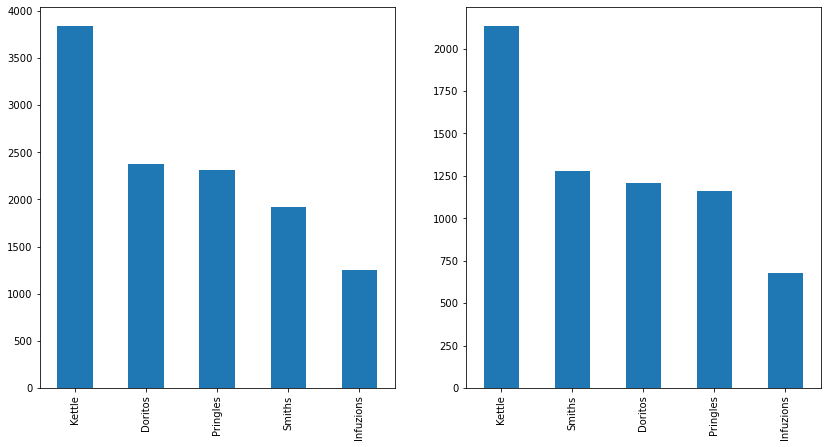

In [226]:
ax, fig = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
plt.subplot(1,2,1)
main_young['BRAND'].value_counts().head().plot.bar()
plt.subplot(1,2,2)
main_mid['BRAND'].value_counts().head().plot.bar()

Observation:
- Kettle, Doritos, and Pringles were the most popular brands among mainstream - young singles and couples.
- Mainstream - midage singles/couples purchased Kettle brand followed by Smiths and Doritos more often than other brands

### <a id='3.6.2' >3.6.2 Packet size preference </a>

In [227]:
main_young['PACKET_SIZE'].value_counts()

175    4997
150    3080
134    2315
110    2051
170    1575
330    1195
165    1102
380     626
270     620
210     576
135     290
250     280
200     179
190     148
90      128
160     128
180      70
70       63
220      62
125      59
Name: PACKET_SIZE, dtype: int64

In [228]:
main_mid['PACKET_SIZE'].value_counts()

175    2975
150    1777
134    1159
110    1124
170     882
330     668
165     641
270     343
380     310
210     307
135     163
250     147
200     132
190     116
160     101
90       69
70       50
220      48
180      48
125      35
Name: PACKET_SIZE, dtype: int64

<AxesSubplot:>

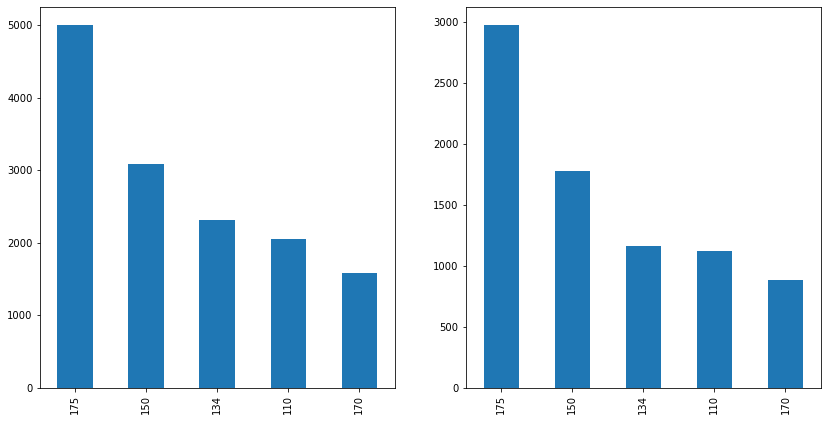

In [229]:
ax, fig = plt.subplots(nrows=1, ncols=2, figsize = (14,7))
plt.subplot(1,2,1)
main_young['PACKET_SIZE'].value_counts().head().plot.bar()
plt.subplot(1,2,2)
main_mid['PACKET_SIZE'].value_counts().head().plot.bar()

Observation:
- The 175g, 150g and 134g chips were the top three most preferred sizes by both customer segments 
- The 175g sized chip was purchased about 5000 times by mainstream - young singles/couples, compared to little under 3000 times by midage - young singles/couples.

## <a id='3.7' > 3.7 Additional Insights </a> 

In [230]:
df['MONTH'].value_counts()

12    21225
3     21124
7     21016
8     20864
5     20832
10    20772
1     20610
6     20362
11    20353
9     20296
4     20281
2     19005
Name: MONTH, dtype: int64

Observation:
- Chip sales were evenly distributed throughout the year, with holiday periods slightly outperforming the rest.
- The second largest month for sales was March, which could be attributable to the Easter break, which falls around this time.

In [231]:
df['DAY_OF_WEEK'].value_counts()

6    36109
4    35704
2    35347
5    35152
0    34975
3    34843
1    34610
Name: DAY_OF_WEEK, dtype: int64

Observation:
- Sunday was the day of the week with the highest sales followed by friday although there was only a minor difference in sales among all the days of the weeks 

<AxesSubplot:xlabel='PACKET_SIZE,BRAND'>

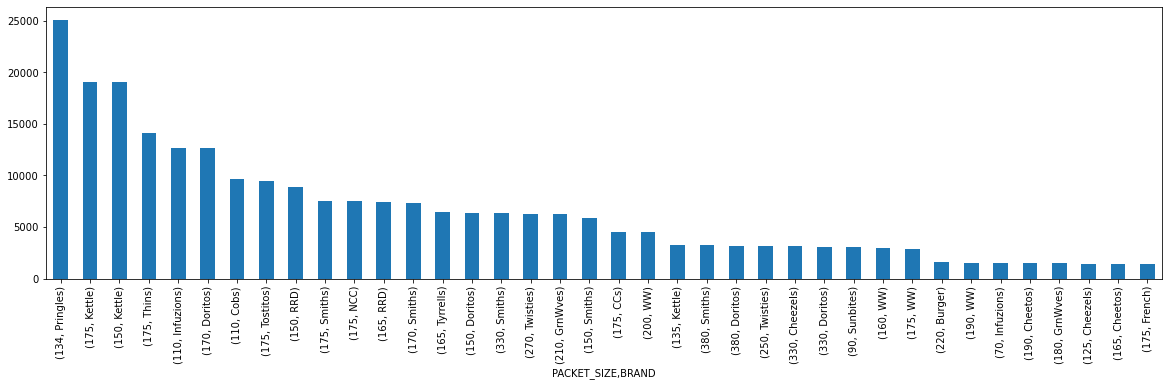

In [232]:
df.groupby(['PACKET_SIZE', 'BRAND']).count()['PROD_QTY'].sort_values(ascending=False).plot.bar(figsize = (20,5))

Observation:
- The most preferred brand and size combination was 134g Pringles.
- 175g and 150g kettle were the second most purchased brand - size combination

# <a id='4'>4. Conclusion and Recommendation </a>

## <a id='4.1' > 4.1 Conclusion </a> 

Budget - older families were the highest-spending consumer segment, followed by mainstream - young singles/couples and mainstream - retirees. However, the high revenue generated from mainstream - young singles/couples was owing to its bigger customer size  compared to budget - elderly families who had a relatively smaller number of customers.

Families also tend to buy more chips on average than any other customer segment, with the exception of new families. Furthermore, mainstream singles and couples, both young and middle-aged, spent substantially more on average than premium and budget counterparts.

Finally, Kettle was by far the most preferred brand, with the 175g size chips being the most popular.

## <a id='4.2' > 4.2 Recommendation </a> 

Mainstream - young and middle-aged singles/couples are the average biggest spenders, thus I recommend that the supermarket concentrate on growing this consumer segment in the second half of the year to increase sales. Furthermore, I suggest that the supermarket add more Kettle brand chips to their stock, as well as the 175g sized chip, due to the huge demand for this brand of chip among mainstream - young and middle-aged singles and couples.